Imports & load

In [2]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE, chi2

In [3]:
df = pd.read_csv("../data/heart_disease_clean.csv")
X = df.drop(columns=["target"])
y = df["target"]


In [4]:
cat_cols = ["sex","cp","fbs","restecg","exang","slope","thal","ca"]
num_cols = ["age","trestbps","chol","thalach","oldpeak"]


try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

pre = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imp", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_cols),
        ("cat", Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("ohe", ohe)
        ]), cat_cols),
    ]
)



In [5]:
def get_feature_names(preprocessor, num_cols, cat_cols):
    names = []
    names.extend(num_cols)
    if len(cat_cols):
        ohe_step = preprocessor.named_transformers_["cat"].named_steps["ohe"]
        names.extend(list(ohe_step.get_feature_names_out(cat_cols)))
    return names

Random Forest feature importance on preprocessed matrix

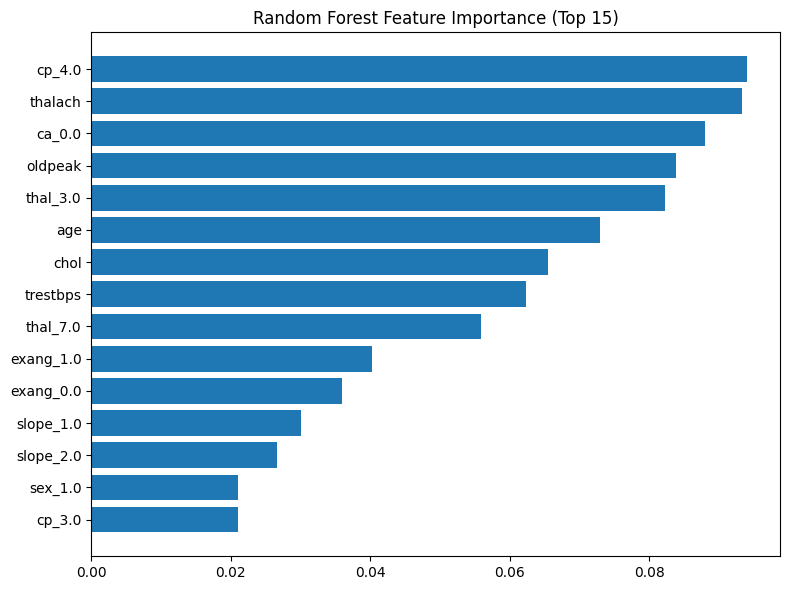

In [6]:
rf_pipe = Pipeline([("pre", pre),
                    ("rf", RandomForestClassifier(n_estimators=300, random_state=42))])
rf_pipe.fit(X, y)

feature_names = get_feature_names(rf_pipe.named_steps["pre"], num_cols, cat_cols)
importances = rf_pipe.named_steps["rf"].feature_importances_
fi = (pd.DataFrame({"feature": feature_names, "importance": importances})
        .sort_values("importance", ascending=False)
        .reset_index(drop=True))

# Plot top-15
plt.figure(figsize=(8,6))
top = fi.head(15).sort_values("importance")
plt.barh(top["feature"], top["importance"])
plt.title("Random Forest Feature Importance (Top 15)")
plt.tight_layout(); plt.show()

RFE with Logistic Regression (on preprocessed X)

In [7]:
# Prepare transformed X (dense)
Xt = pre.fit_transform(X)   # fit a clean copy to capture encoder state
if hasattr(Xt, "toarray"):  # if sparse, densify
    Xt = Xt.toarray()
feature_names = get_feature_names(pre, num_cols, cat_cols)  # refresh names matching this 'pre'

logit = LogisticRegression(max_iter=2000, solver="lbfgs")  # lbfgs works fine for RFE here
rfe = RFE(estimator=logit, n_features_to_select=10, step=1)
rfe.fit(Xt, y)

selected_rfe = np.array(feature_names)[rfe.get_support()]
selected_rfe = list(selected_rfe)


Chi-square

In [8]:
pre_chi = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imp", SimpleImputer(strategy="median")),
            ("minmax", MinMaxScaler())   # non-negative
        ]), num_cols),
        ("cat", Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("ohe", ohe)
        ]), cat_cols),
    ]
)
Xt_chi = pre_chi.fit_transform(X)
if hasattr(Xt_chi, "toarray"):
    Xt_chi = Xt_chi.toarray()
feature_names_chi = get_feature_names(pre_chi, num_cols, cat_cols)

chi_scores, pvals = chi2(Xt_chi, y)
chi_df = (pd.DataFrame({"feature": feature_names_chi, "chi2": chi_scores, "pval": pvals})
            .sort_values("chi2", ascending=False)
            .reset_index(drop=True))


Final selection strategy

In [9]:
top_rf   = set(fi.head(10)["feature"])
top_chi  = set(chi_df.head(10)["feature"])
sel = sorted(top_rf.union(top_chi).union(set(selected_rfe)))
print("Selected features (union of RF top10, Chi2 top10, RFE 10):")
print(sel)

Selected features (union of RF top10, Chi2 top10, RFE 10):
['age', 'ca_0.0', 'ca_2.0', 'chol', np.str_('cp_1.0'), 'cp_3.0', 'cp_4.0', 'exang_0.0', 'exang_1.0', 'oldpeak', np.str_('sex_0.0'), np.str_('sex_1.0'), 'slope_1.0', 'slope_2.0', 'thal_3.0', 'thal_7.0', 'thalach', 'trestbps']


Save reduced dataset (transformed matrix -> DataFrame -> select 'sel')

In [10]:
X_reduced = pre.fit_transform(X)
if hasattr(X_reduced, "toarray"):
    X_reduced = X_reduced.toarray()
feature_names_final = get_feature_names(pre, num_cols, cat_cols)

X_reduced_df = pd.DataFrame(X_reduced, columns=feature_names_final)
X_sel = X_reduced_df[sel]

out = pd.concat([X_sel.reset_index(drop=True), y.reset_index(drop=True)], axis=1)
out.to_csv("../data/heart_selected.csv", index=False)
fi.to_csv("../results/feature_importance_rf.csv", index=False)
chi_df.to_csv("../results/feature_chi2.csv", index=False)

print("Saved ../data/heart_selected.csv", out.shape)
print("Also saved RF importances and Chi2 rankings in ../results/")


Saved ../data/heart_selected.csv (303, 19)
Also saved RF importances and Chi2 rankings in ../results/
